## Basic setup, FER2018 and libraries import



In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings

# The following line disables warning messages. This can help keep the output clean.
warnings.filterwarnings("ignore")
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from IPython.display import Image as DisplayImage
import torch.nn as nn
from collections import defaultdict
import PIL
import io
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import json

# This integrates tqdm with pandas so you can use a progress bar on pandas operations.
tqdm.pandas()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import zipfile

### Setup for Google Colab

In [33]:
from google.colab.output import eval_js
from google.colab import output

In [34]:
from google.colab import drive
# Mount Google Drive to access and save files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os
# Set Kaggle config directory in Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [36]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [37]:
!kaggle datasets download -d ashishpatel26/fer2018

Dataset URL: https://www.kaggle.com/datasets/ashishpatel26/fer2018
License(s): copyright-authors
 98% 95.0M/96.6M [00:05<00:00, 24.9MB/s]
100% 96.6M/96.6M [00:05<00:00, 18.1MB/s]


In [38]:
%ls

best_model.pth  fer2018.zip        photo_with_predictions_gradcam.jpg  training_metrics.json
fer20131.csv    ferSubmission.csv  photo_with_predictions_opencv.jpg
fer2013.bib     photo.jpg          README


In [39]:
# Extracting files
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [40]:
%ls

best_model.pth  ferSubmission.csv                   photo_with_predictions_opencv.jpg
fer20131.csv    photo.jpg                           README
fer2013.bib     photo_with_predictions_gradcam.jpg  training_metrics.json


### Setup for local machine
##### You need those libraries: pip install kaggle pandas numpy matplotlib torch torchvision tqdm opencv-python-headless

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/"
# Set Kaggle config directory locally
!kaggle datasets download -d ashishpatel26/fer2018

Dataset URL: https://www.kaggle.com/datasets/ashishpatel26/fer2018
License(s): copyright-authors
 98% 95.0M/96.6M [00:05<00:00, 25.6MB/s]
100% 96.6M/96.6M [00:05<00:00, 19.3MB/s]


In [ ]:
# Extracting files
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

### General dataset setup

In [10]:
dataset=pd.read_csv("fer20131.csv")

In [11]:
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

  0%|          | 0/7 [00:00<?, ?it/s]

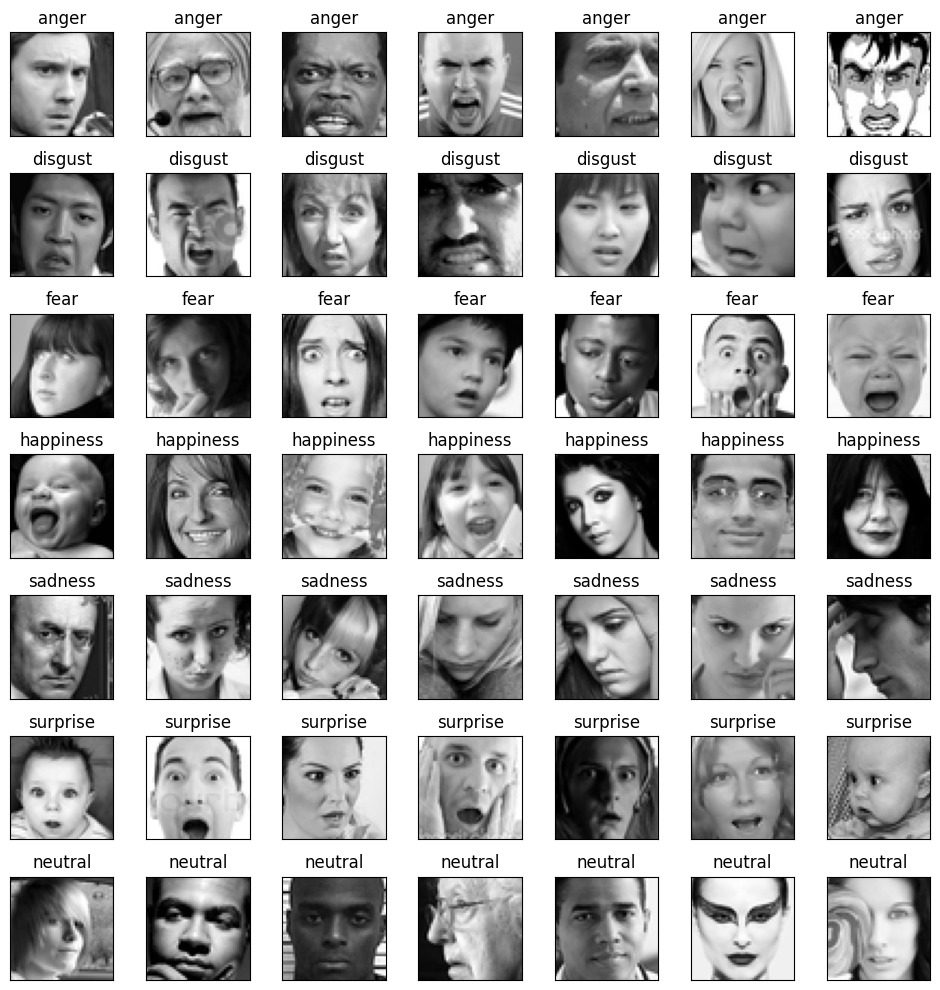

In [12]:
# Displaying samples of photos for each class
fig = plt.figure(1, (10, 10))

k = 0
for label in tqdm(sorted(dataset.emotion.unique())):
    for j in range(7):
        px = dataset[dataset.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

In [13]:
# Showing proportions between classes
dataset["emotion"].value_counts(normalize=True)*100

,proportion
emotion,
3,25.048068
6,17.270878
4,16.933709
2,14.269791
0,13.801655
5,11.151671
1,1.524229


### Data Augmentation because of imbalanced classes

In [14]:
# Setting DataFrames
train_df = dataset[dataset["Usage"] == "Training"]
val_df = dataset[dataset["Usage"] == "PublicTest"]
test_df = dataset[dataset["Usage"] == "PrivateTest"]

In [15]:
# Calculate the class distribution
class_counts = train_df['emotion'].value_counts()

# Find the majority class
majority_class = class_counts.index[0]
majority_class_count = class_counts[majority_class]

# Find the minority classes and their counts
minority_classes = class_counts[class_counts < majority_class_count].index

# Data augmentation for minority classes
augmented_data = []

for emotion in minority_classes:
    minority_df = train_df[train_df['emotion'] == emotion]
    num_to_augment = int(majority_class_count - len(minority_df))

    for _ in range(num_to_augment):
      # Randomly select an image from the minority class
      random_index = np.random.choice(minority_df.index)
      pixels = minority_df.loc[random_index, 'pixels']

      # Apply random transformations
      pixels_array = np.array(pixels.split(' '), dtype=np.uint8).reshape(48, 48)
      noise = np.random.normal(0, 5, (48,48))
      noisy_pixels_array = np.clip(pixels_array + noise, 0, 255).astype(np.uint8)

      augmented_pixels = ' '.join(map(str, noisy_pixels_array.flatten()))
      augmented_data.append({'emotion': emotion, 'pixels': augmented_pixels, 'Usage': 'Training'})

# Create a new DataFrame from augmented data and concatenate it with the previous training DataFrame
augmented_df = pd.DataFrame(augmented_data)
train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Verifying class distribution after augmentation
print(train_df["emotion"].value_counts(normalize=True)*100)

emotion
0    14.285714
2    14.285714
4    14.285714
6    14.285714
3    14.285714
5    14.285714
1    14.285714
Name: proportion, dtype: float64


In [16]:
# Verify the final quantity of samples for each class for training, validating, and testing DataFrames
print("Train DataFrame:")
print(train_df["emotion"].value_counts())
print("\nValidation DataFrame:")
print(val_df["emotion"].value_counts())
print("\nTest DataFrame:")
print(test_df["emotion"].value_counts())

Train DataFrame:
emotion
0    7215
2    7215
4    7215
6    7215
3    7215
5    7215
1    7215
Name: count, dtype: int64

Validation DataFrame:
emotion
3    895
4    653
6    607
2    496
0    467
5    415
1     56
Name: count, dtype: int64

Test DataFrame:
emotion
3    879
6    626
4    594
2    528
0    491
5    416
1     55
Name: count, dtype: int64


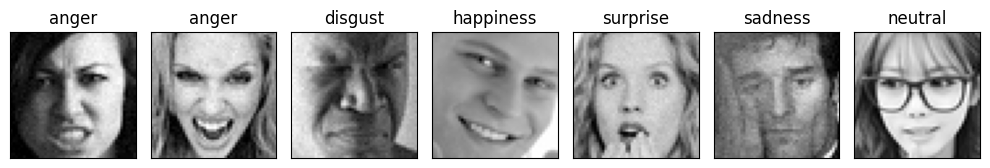

In [17]:
fig = plt.figure(figsize=(10, 10))

# Sample 7 random rows from train_df
random_indices = np.random.choice(train_df.index, size=7, replace=False)
k=0
for index in random_indices:
    px = train_df.loc[index, 'pixels']
    label = train_df.loc[index, 'emotion']
    px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

    k += 1
    ax = plt.subplot(1,7, k)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotions[label])
    plt.tight_layout()

plt.show()

## Data Transformation into tensor dataset

In [18]:
class FER2018Dataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = {0: 'Angry',
                        1: 'Disgust',
                        2: 'Fear',
                        3: 'Happy',
                        4: 'Sad',
                        5: 'Surprise',
                        6: 'Neutral'}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['emotion'])

        # Load the image as a single-channel grayscale image
        img = np.array(row["pixels"].split(' '), dtype=np.uint8).reshape(48, 48)

        # Convert NumPy array to PIL Image (grayscale)
        img = Image.fromarray(img, mode='L')  # 'L' mode for 8-bit pixels (grayscale)

        if self.transform:
            img = self.transform(img)

        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [19]:
# Transformations for grayscale images
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize for single channel
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize for single channel
])

# Setting DataSets
train_dataset = FER2018Dataset(train_df, train_transform)
val_dataset = FER2018Dataset(val_df, test_transform)
test_dataset = FER2018Dataset(test_df, test_transform)

In [20]:
# Setting batch size and configuring the DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1, pin_memory=True)

## Base-Model

### Second try (BEST ONE SO FAR)
### Epoch: 21, Train loss: 0.6590, Train acc: 0.7565, Val loss: 0.9907, Val acc: 0.6475

In [21]:
# Different settings of VGGs
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# Model definition
class VGG(nn.Module):
    def __init__(self, vgg_name, in_channels=1):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name], in_channels)
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg, in_channels):
        layers = []
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=False)]
                in_channels = x  # Update the number of input channels for the next layer
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# Instantiate the model for grayscale images. VGG19 obtained better results.
model = VGG('VGG19', in_channels=1)


### Third try (ResNET)
#### Results: Epoch: 14, Train loss: 0.6739, Train acc: 0.7508, Val loss: 1.1760, Val acc: 0.6048

In [ ]:
# Load model
model = models.resnet50(pretrained=True)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Set 7 classes (according to expressions)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training


In [22]:
# Checking which device is being used
if torch.cuda.is_available():
    device = torch.device('cuda')
    model=model.cuda()
else:
    device = torch.device('cpu')
print(device)

cuda


In [23]:
def accuracy(outputs, labels):
    """
    Calculates the accuracy of model predictions.

    Args:
        outputs (torch.Tensor): The model's raw output predictions.
        labels (torch.Tensor): The true labels for the data.

    Returns:
        torch.Tensor: The accuracy as a float value between 0 and 1, representing the proportion of correct predictions.
    """
    _, preds = torch.max(outputs, dim=1)
    return (preds == labels).float().mean()

In [24]:
def train(model, dataloader, optimizer, loss_fn):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for model parameter updates.
        loss_fn (torch.nn.Module): Loss function.

    Returns:
        tuple: Average training loss and accuracy for the epoch.
    """
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for data in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = data['image'].to(device), data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [25]:
def validate(model, dataloader, optimizer, loss_fn):
    """
    Validate the model for one epoch.

    Args:
        model (torch.nn.Module): The model to validate.
        dataloader (torch.utils.data.DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for the model.
        loss_fn (torch.nn.Module): Loss function.

    Returns:
        tuple: Average validation loss and accuracy for the epoch.
    """
    model.eval()

    valid_running_loss = 0.0
    vaild_running_acc = 0.0

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)

    return valid_loss, valid_acc

In [26]:
# loss function and optimizer
epochs = 50
lr = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [27]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, epochs + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)

    # Save metrics
    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())

    print(f'Epoch: {epoch}, '
          f'Train loss: {train_epoch_loss:.4f}, '
          f'Train acc: {train_epoch_acc:.4f}, '
          f'Val loss: {val_epoch_loss:.4f}, '
          f'Val acc: {val_epoch_acc:.4f}')

    # Early stopping logic
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0

        # Save the best model
        torch.save(model.state_dict(), '/content/best_model.pth')

        metrics = {
          "train_loss": [float(loss) for loss in train_loss],
          "val_loss": [float(loss) for loss in val_loss],
          "train_acc": [float(acc) for acc in train_acc],
          "val_acc": [float(acc) for acc in val_acc],
        }

        with open("training_metrics.json", "w") as f:
          json.dump(metrics, f)

        print("Validation loss improved. Model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Check if early stopping is triggered
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch} epochs.")
        break

print('DONE TRAINING')

Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1, Train loss: 1.9546, Train acc: 0.1768, Val loss: 1.9545, Val acc: 0.1521
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2, Train loss: 1.6742, Train acc: 0.3351, Val loss: 1.4642, Val acc: 0.4185
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3, Train loss: 1.3718, Train acc: 0.4678, Val loss: 1.2927, Val acc: 0.5014
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4, Train loss: 1.2526, Train acc: 0.5159, Val loss: 1.2049, Val acc: 0.5366
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5, Train loss: 1.1727, Train acc: 0.5491, Val loss: 1.2338, Val acc: 0.5355
No improvement in validation loss for 1 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6, Train loss: 1.1134, Train acc: 0.5704, Val loss: 1.2165, Val acc: 0.5302
No improvement in validation loss for 2 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7, Train loss: 1.0652, Train acc: 0.5897, Val loss: 1.1874, Val acc: 0.5512
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8, Train loss: 1.0258, Train acc: 0.6077, Val loss: 1.1203, Val acc: 0.5794
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.9852, Train acc: 0.6217, Val loss: 1.0889, Val acc: 0.5884
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.9510, Train acc: 0.6375, Val loss: 1.0500, Val acc: 0.6067
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.9170, Train acc: 0.6524, Val loss: 1.1069, Val acc: 0.6051
No improvement in validation loss for 1 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.8847, Train acc: 0.6634, Val loss: 1.1300, Val acc: 0.5886
No improvement in validation loss for 2 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.8631, Train acc: 0.6742, Val loss: 1.0569, Val acc: 0.6221
No improvement in validation loss for 3 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.8333, Train acc: 0.6843, Val loss: 1.0478, Val acc: 0.6235
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.8106, Train acc: 0.6935, Val loss: 1.0320, Val acc: 0.6207
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 16, Train loss: 0.7859, Train acc: 0.7050, Val loss: 1.0352, Val acc: 0.6254
No improvement in validation loss for 1 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 17, Train loss: 0.7650, Train acc: 0.7116, Val loss: 1.0393, Val acc: 0.6325
No improvement in validation loss for 2 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 18, Train loss: 0.7471, Train acc: 0.7213, Val loss: 1.0137, Val acc: 0.6385
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 19, Train loss: 0.7251, Train acc: 0.7291, Val loss: 1.0297, Val acc: 0.6360
No improvement in validation loss for 1 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 20, Train loss: 0.7068, Train acc: 0.7352, Val loss: 1.0613, Val acc: 0.6339
No improvement in validation loss for 2 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 21, Train loss: 0.6831, Train acc: 0.7473, Val loss: 1.0325, Val acc: 0.6328
No improvement in validation loss for 3 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 22, Train loss: 0.6635, Train acc: 0.7543, Val loss: 1.0131, Val acc: 0.6538
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 23, Train loss: 0.6460, Train acc: 0.7627, Val loss: 1.0028, Val acc: 0.6615
Validation loss improved. Model saved.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 24, Train loss: 0.6273, Train acc: 0.7689, Val loss: 1.0625, Val acc: 0.6453
No improvement in validation loss for 1 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 25, Train loss: 0.6058, Train acc: 0.7780, Val loss: 1.1072, Val acc: 0.6202
No improvement in validation loss for 2 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 26, Train loss: 0.5825, Train acc: 0.7871, Val loss: 1.0573, Val acc: 0.6416
No improvement in validation loss for 3 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 27, Train loss: 0.5689, Train acc: 0.7937, Val loss: 1.1179, Val acc: 0.6232
No improvement in validation loss for 4 epochs.


Training...:   0%|          | 0/790 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 28, Train loss: 0.5581, Train acc: 0.7991, Val loss: 1.0696, Val acc: 0.6402
No improvement in validation loss for 5 epochs.
Early stopping triggered after 28 epochs.
DONE TRAINING


## Results

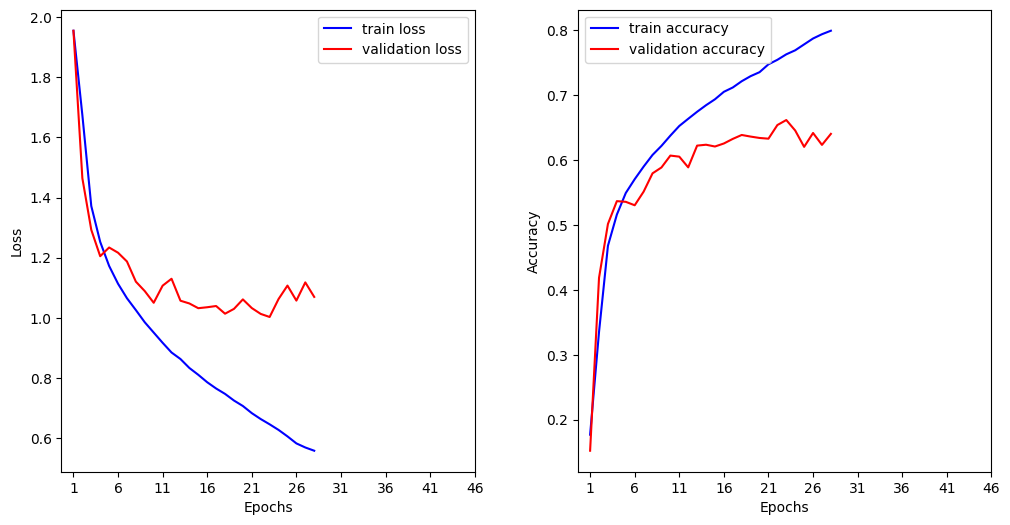

In [28]:
# Loss plots
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.xticks(range(0, epochs, max(1, epochs // 10)), range(1, epochs + 1, max(1, epochs // 10)))

plt.ylabel('Loss')
plt.legend()

# Accuracy plots
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validation accuracy')
plt.xlabel('Epochs')
plt.xticks(range(0, epochs, max(1, epochs // 10)), range(1, epochs + 1, max(1, epochs // 10)))

plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

In [29]:
classes = list(test_dataset.classes.values())

def test(model, dataloader):
    """
    Evaluates the model's performance on the test dataset.

    Args:
        model (torch.nn.Module): The trained model to be tested.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the test dataset.

    Returns:
        correct_pred (defaultdict): A dictionary containing the count of correct predictions for each class.
        total_pred (defaultdict): A dictionary containing the total number of predictions for each class.
        all_labels (list): A list of all true labels in the test dataset.
        all_predictions (list): A list of all predicted labels from the test dataset.
    """
    model.eval()

    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)

            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

In [30]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.5743
Accuracy for class: Sad   is 0.3939
Accuracy for class: Happy is 0.8407
Accuracy for class: Fear  is 0.5379
Accuracy for class: Surprise is 0.8221
Accuracy for class: Neutral is 0.6805
Accuracy for class: Disgust is 0.7273
Total accuracy: 0.6539


In [31]:
# Calculating metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=classes))


Accuracy: 0.6539
Precision: 0.6574
Recall: 0.6539
F1-score: 0.6528

Classification Report:
              precision    recall  f1-score   support

       Angry       0.60      0.57      0.59       491
     Disgust       0.73      0.73      0.73        55
        Fear       0.45      0.54      0.49       528
       Happy       0.89      0.84      0.87       879
         Sad       0.52      0.39      0.45       594
    Surprise       0.75      0.82      0.79       416
     Neutral       0.61      0.68      0.64       626

    accuracy                           0.65      3589
   macro avg       0.65      0.65      0.65      3589
weighted avg       0.66      0.65      0.65      3589



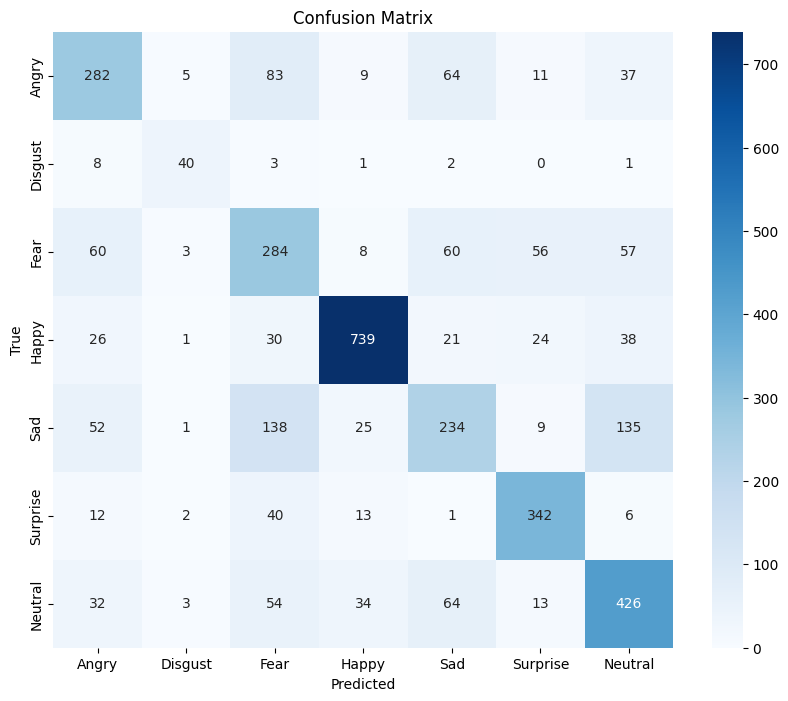

In [32]:
classes = list(test_dataset.classes.values())

# Creating confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Demo


### Load a model already trained

In [ ]:
# Accessing the file with trained parameters and loading them into the model
state_dict = torch.load('/content/best_model.pth', map_location=torch.device('cpu'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VGG('VGG19', in_channels=1)
model.load_state_dict(state_dict)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

### For COLAB: Set and run camera application

In [41]:
def js_to_image(js_reply):
  """
  Function to convert the JavaScript object into an OpenCV image
  Args:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def bbox_to_bytes(bbox_array):
  """
  Function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
  Args:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [42]:
# JavaScript to properly create camera video stream
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  """
  Sends a video frame with a label and bounding box to the JavaScript stream.

  Args:
      label (str): Label to display on the video frame.
      bbox (str): Bounding box data in string format.

  Returns:
      dict: Frame data including timing and image information.
  """
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [43]:
# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [45]:
# Start streaming video from webcam
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])

    # Convert the frame to grayscale for model prediction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))

    # Process each detected face, detecting the emotion and drawing the bounding box
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        try:
            face_roi = gray[y:y + h, x:x + w]  # Extract face region
            face_roi = cv2.resize(face_roi, (48, 48))  # Resize to match model input
            face_roi = face_roi / 255.0  # Normalize pixel values
            face_roi = np.expand_dims(face_roi, axis=(0, 1))  # Add batch and channel dimensions

            # Convert to PyTorch tensor
            data = torch.tensor(face_roi, dtype=torch.float32).to(device)

            with torch.no_grad():
                outputs = model(data)
                preds = F.softmax(outputs, dim=1)
                prediction = torch.argmax(preds).item()

            emotion_label = emotions[prediction]

            # Display the emotion label on the frame
            cv2.putText(
                img,
                emotion_label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )
        except Exception as e:
            print(f"Error processing face ROI: {e}")

    # Convert the frame to RGBA for rendering
    rgba_frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(rgba_frame)

    # Update bbox for the next frame
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

#### With grad cam


In [46]:
def eval_js(script):
    """
    Executes a JavaScript script in the browser environment.

    Args:
        script (str): The JavaScript code to execute.

    Returns:
        The result of the JavaScript execution.
    """
    return output.eval_js(script)

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, target_class=None):
    """
    Generates a Grad-CAM heatmap for visualizing the important regions in an image for a given class.

    Args:
        img_tensor (torch.Tensor): The input image tensor, typically with shape (batch_size, channels, height, width).
        model (torch.nn.Module): The pre-trained model used for predictions.
        last_conv_layer_name (str): The name of the last convolutional layer in the model.
        target_class (int, optional): The class index for which to generate the heatmap. If None, the class with the highest score is used.

    Returns:
        np.ndarray: The generated Grad-CAM heatmap as a 2D numpy array (height, width).
    """
    # Retrieve the actual convolutional layer module
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]

    # Store activations and gradients
    activations = []
    gradients = []

    def save_activations_hook(module, input, output):
        activations.append(output.detach().clone())

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach().clone())

    forward_handle = last_conv_layer.register_forward_hook(save_activations_hook)
    backward_handle = last_conv_layer.register_full_backward_hook(save_gradients_hook)

    model.eval()
    preds = model(img_tensor)
    if target_class is None:
        target_class = torch.argmax(preds, dim=1).item()

    model.zero_grad()
    class_score = preds[:, target_class]
    class_score.backward()

    forward_handle.remove()
    backward_handle.remove()

    activations = activations[0].cpu().numpy()
    gradients = gradients[0].cpu().numpy()

    # Compute weights
    weights = np.mean(gradients, axis=(2, 3))

    # Compute CAM
    cam = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]

    cam = np.maximum(cam, 0)
    if cam.max() != 0:
        cam /= cam.max()

    return cam

model.to(device)
model.eval()

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

last_conv_layer_name = "features.49"

# Start streaming video from the webcam
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])

    # Convert the frame to grayscale for model prediction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))

    # Process each detected face, detecting the emotion and drawing the bounding box with the heatmap
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        try:
            face_roi = gray[y:y + h, x:x + w]
            face_roi = cv2.resize(face_roi, (48, 48))
            face_roi = face_roi / 255.0
            face_roi = np.expand_dims(face_roi, axis=(0, 1))

            # Convert to PyTorch tensor
            data = torch.tensor(face_roi, dtype=torch.float32).to(device)

            # Predict emotions using the model
            with torch.no_grad():
                outputs = model(data)
                preds = F.softmax(outputs, dim=1)
                prediction = torch.argmax(preds).item()

            # Get the emotion label
            emotion_label = emotions[prediction]

            # Compute Grad-CAM heatmap for the face
            cam = make_gradcam_heatmap(data, model, last_conv_layer_name, target_class=prediction)

            # Resize the heatmap to the size of the face ROI
            heatmap = cv2.resize(cam, (w, h))
            heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

            # Overlay the Grad-CAM heatmap on the face region
            face_overlay = cv2.addWeighted(img[y:y + h, x:x + w], 0.6, heatmap, 0.4, 0)
            img[y:y + h, x:x + w] = face_overlay

            # Display the emotion label on the frame
            cv2.putText(
                img,
                emotion_label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )

        except Exception as e:
            print(f"Error processing face ROI: {e}")

    # Convert the frame to RGBA for rendering
    rgba_frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(rgba_frame)

    # Update bbox for the next frame
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

#### Take a picture and detect emotion

<IPython.core.display.Javascript object>

Saved to /content/photo.jpg


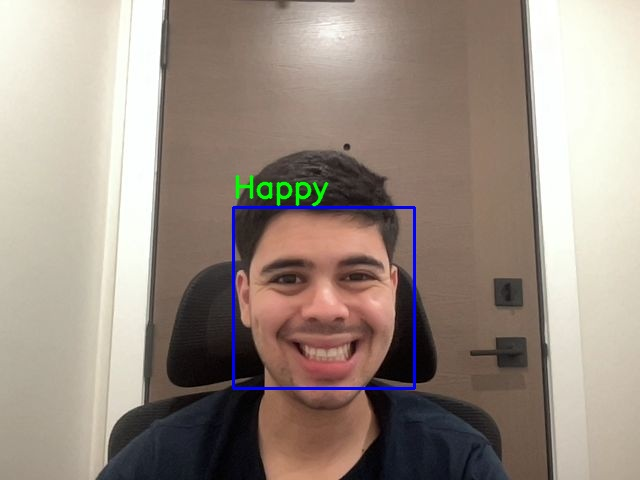

Prediction completed. Result saved to photo_with_predictions_opencv.jpg


In [ ]:
# Function to capture a photo from the webcam
def take_photo(filename='/content/photo.jpg', quality=0.8):
    """
    Captures a photo from the webcam and saves it to the specified file.

    Args:
        filename (str, optional): The path to save the captured photo. Default is '/content/photo.jpg'.
        quality (float, optional): The quality of the captured image (0.0 to 1.0). Default is 0.8.

    Returns:
        str: The filename where the captured photo is saved.
    """
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def predict_emotion(image_path, model, emotions, face_cascade):
    """
    Predicts the emotion of faces detected in the input image and overlays the emotion labels on the image.

    Args:
        image_path (str): The path to the image file to process.
        model (torch.nn.Module): The trained emotion classification model.
        emotions (list): A list of emotion labels corresponding to model output classes.
        face_cascade (cv2.CascadeClassifier): The OpenCV face detection classifier.

    Returns:
        str: The path to the saved image with overlaid emotion labels.
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Process each detected face, detecting the emotion and drawing the bounding box
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Extract face region of interest (ROI)
        try:
            face_roi = gray[y:y + h, x:x + w]  # Crop face
            face_roi = cv2.resize(face_roi, (48, 48))  # Resize to match model input
            face_roi = face_roi / 255.0  # Normalize pixel values
            face_roi = np.expand_dims(face_roi, axis=(0, 1))  # Add batch and channel dimensions

            face_tensor = torch.tensor(face_roi, dtype=torch.float32).to(device)

            with torch.no_grad():
                outputs = model(face_tensor)
                preds = F.softmax(outputs, dim=1)
                prediction = torch.argmax(preds).item()

            emotion_label = emotions[prediction]

            # Overlay emotion label on the image
            cv2.putText(
                img,
                emotion_label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,  # Font scale
                (0, 255, 0),  # Text color
                2,  # Line thickness
                cv2.LINE_AA,
            )
        except Exception as e:
            print(f"Error processing face ROI: {e}")

    output_path = "photo_with_predictions_opencv.jpg"
    cv2.imwrite(output_path, img)

    from IPython.display import Image, display
    display(Image(output_path))

    return output_path

model.eval()

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Capture photo and predict emotion
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Predict emotion and display the result
    output_filename = predict_emotion(filename, model, emotions, face_cascade)
    print('Prediction completed. Result saved to {}'.format(output_filename))
except Exception as err:
    print(str(err))


##### With grad cam

<IPython.core.display.Javascript object>

Saved to /content/photo.jpg


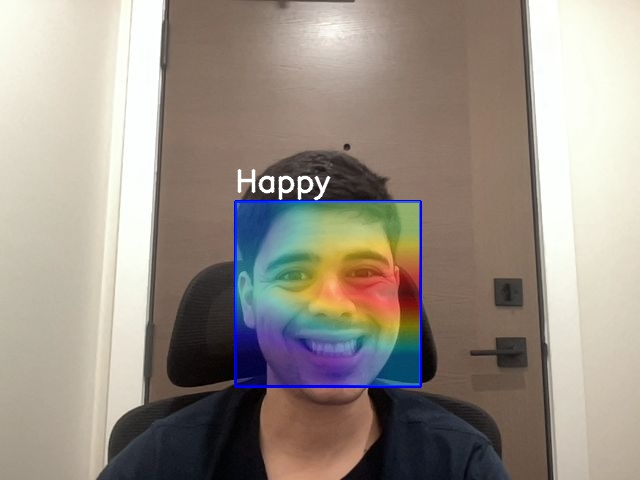

Prediction with Grad-CAM completed. Result saved to /content/photo_with_predictions_gradcam.jpg


In [ ]:
def eval_js(script):
    """
    Executes a JavaScript script in the browser environment.

    Args:
        script (str): The JavaScript code to execute.

    Returns:
        The result of the JavaScript execution.
    """
    return output.eval_js(script)

def take_photo(filename='/content/photo.jpg', quality=0.8):
    """
    Captures a photo from the webcam and saves it to the specified file.

    Args:
        filename (str, optional): The path to save the captured photo. Default is '/content/photo.jpg'.
        quality (float, optional): The quality of the captured image (0.0 to 1.0). Default is 0.8.

    Returns:
        str: The filename where the captured photo is saved.
    """
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, target_class=None):
    """
    Computes the Grad-CAM heatmap for a given image tensor and model.

    Args:
        img_tensor (torch.Tensor): The input image tensor for which the Grad-CAM heatmap is computed.
        model (torch.nn.Module): The trained model for making predictions.
        last_conv_layer_name (str): The name of the last convolutional layer in the model.
        target_class (int, optional): The class index for which to compute the heatmap. If None, the class with
                                      the highest model output score is used.

    Returns:
        np.ndarray: The Grad-CAM heatmap corresponding to the target class, normalized and resized to match
                    the input image dimensions.
    """
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]

    activations = []
    gradients = []

    def save_activations_hook(module, input, output):
        activations.append(output.detach().clone())

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach().clone())

    # Register hooks on the actual conv layer
    forward_handle = last_conv_layer.register_forward_hook(save_activations_hook)
    backward_handle = last_conv_layer.register_full_backward_hook(save_gradients_hook)

    model.eval()
    preds = model(img_tensor)
    if target_class is None:
        target_class = torch.argmax(preds, dim=1).item()

    # Backward pass
    model.zero_grad()
    class_score = preds[:, target_class]
    class_score.backward()

    # Remove hooks to avoid conflicts in subsequent runs
    forward_handle.remove()
    backward_handle.remove()

    activations = activations[0].cpu().numpy()
    gradients = gradients[0].cpu().numpy()

    # Compute weights for each channel
    weights = np.mean(gradients, axis=(2, 3))

    # Compute Grad-CAM
    cam = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]

    # Apply ReLU and normalize
    cam = np.maximum(cam, 0)
    if cam.max() != 0:
        cam /= cam.max()

    return cam

def predict_emotion_with_gradcam(image_path, model, emotions, face_cascade, last_conv_layer_name):
    """
    Predicts the emotion from a facial image and apply a Grad-CAM heatmap for each detected face.

    Args:
        image_path (str): Path to the input image containing faces.
        model (torch.nn.Module): The trained model for emotion prediction.
        emotions (list): A list of emotion labels corresponding to model output classes.
        face_cascade (cv2.CascadeClassifier): Pre-trained classifier for detecting faces in the image.
        last_conv_layer_name (str): The name of the last convolutional layer in the model for Grad-CAM generation.

    Returns:
        tuple: A tuple containing:
            - output_path (str): The path to the saved output image with emotion labels and Grad-CAM overlays.
            - heatmaps (list): A list of Grad-CAM heatmaps for each detected face.

    Raises:
        FileNotFoundError: If the input image file cannot be found.
        Exception: If an error occurs during face detection, emotion prediction, or Grad-CAM generation.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file not found: {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    if len(faces) == 0:
        print("No faces detected in the image.")
        return None, None

    heatmaps = []

    # Process each detected face, detecting the emotion and drawing the bounding box with the heatmap
    for (x, y, w, h) in faces:

        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        try:
            face_roi = gray[y:y + h, x:x + w]
            face_roi = cv2.resize(face_roi, (48, 48))
            face_roi = face_roi / 255.0
            face_roi = np.expand_dims(face_roi, axis=0)
            face_roi = np.expand_dims(face_roi, axis=0)
            face_tensor = torch.tensor(face_roi, dtype=torch.float32).to(device)

            with torch.no_grad():
                outputs = model(face_tensor)
                preds = F.softmax(outputs, dim=1)
                prediction = torch.argmax(preds, dim=1).item()

            emotion_label = emotions[prediction]

            cam = make_gradcam_heatmap(face_tensor, model, last_conv_layer_name, target_class=prediction)

            # Resize CAM to match original face ROI size
            heatmap = cv2.resize(cam, (w, h))
            heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

            face_overlay = cv2.addWeighted(img[y:y + h, x:x + w], 0.6, heatmap, 0.4, 0)

            # Replace the face region with the overlay
            img[y:y + h, x:x + w] = face_overlay

            # Add emotion label
            cv2.putText(
                img, emotion_label, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA
            )

            # Append the cam to heatmaps
            heatmaps.append(cam)

        except Exception as e:
            print(f"Error processing face ROI: {e}")

    # Save and display the annotated image
    output_path = "/content/photo_with_predictions_gradcam.jpg"
    cv2.imwrite(output_path, img)
    display(Image(output_path))

    return output_path, heatmaps

model.to(device)
model.eval()

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    last_conv_layer_name = "features.49"
    output_filename, heatmaps = predict_emotion_with_gradcam(filename, model, emotions, face_cascade, last_conv_layer_name)
    if output_filename:
        print(f'Prediction with Grad-CAM completed. Result saved to {output_filename}')
except Exception as err:
    print(f"Error: {err}")


### For LOCAL machine: Run camera with real-time detection

In [ ]:
# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Preprocessing transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Start video capture
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Cannot access the camera.")
    exit()

print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to capture frame.")
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))

    # Process each detected face, detecting the emotion and drawing the bounding box
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        face_roi = gray[y:y + h, x:x + w]
        try:
            face_tensor = transform(face_roi).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(face_tensor)
                preds = F.softmax(outputs, dim=1)
                prediction = torch.argmax(preds).item()

            emotion_label = emotions[prediction]

            # Show Emotion on frame
            cv2.putText(
                frame,
                emotion_label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )
        except Exception as e:
            print(f"Error processing face ROI: {e}")

    cv2.imshow("Emotion Recognition", frame)

    # End camera app when pressing q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to quit.


#### With grad cam

In [ ]:
def eval_js(script):
    return output.eval_js(script)

# Ensure model and device are defined, and the model is loaded.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

# Define your emotion labels
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Define the Grad-CAM function
def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, target_class=None):
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]

    # Store activations and gradients
    activations = []
    gradients = []

    def save_activations_hook(module, input, output):
        activations.append(output.detach().clone())

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach().clone())

    forward_handle = last_conv_layer.register_forward_hook(save_activations_hook)
    backward_handle = last_conv_layer.register_full_backward_hook(save_gradients_hook)

    model.eval()
    preds = model(img_tensor)
    if target_class is None:
        target_class = torch.argmax(preds, dim=1).item()

    model.zero_grad()
    class_score = preds[:, target_class]
    class_score.backward()

    forward_handle.remove()
    backward_handle.remove()

    activations = activations[0].cpu().numpy()
    gradients = gradients[0].cpu().numpy()

    # Compute weights
    weights = np.mean(gradients, axis=(2, 3))

    # Compute CAM
    cam = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]

    cam = np.maximum(cam, 0)
    if cam.max() != 0:
        cam /= cam.max()

    return cam

# Set the last conv layer name according to your model's architecture
# For a VGG-like model, e.g.:
last_conv_layer_name = "features.49"

# Load face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Preprocessing transform for the webcam feed
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Start video capture
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Cannot access the camera.")
    exit()

print("Press 'q' to quit.")

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to capture frame.")
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))

    # Process each detected face, detecting the emotion and drawing the bounding box with the heatmap
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        face_roi = gray[y:y + h, x:x + w]
        try:
            face_tensor = transform(face_roi).unsqueeze(0).to(device)  # [1, 1, 48, 48]

            with torch.no_grad():
                outputs = model(face_tensor)
                preds = F.softmax(outputs, dim=1)
                prediction = torch.argmax(preds, dim=1).item()

            emotion_label = emotions[prediction]

            cam = make_gradcam_heatmap(face_tensor, model, last_conv_layer_name, target_class=prediction)

            # Resize CAM to match original face ROI size
            heatmap = cv2.resize(cam, (w, h))
            heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

            # Overlay the Grad-CAM heatmap on the face region
            face_overlay = cv2.addWeighted(frame[y:y + h, x:x + w], 0.6, heatmap, 0.4, 0)
            frame[y:y + h, x:x + w] = face_overlay

            # Show Emotion on frame
            cv2.putText(
                frame,
                emotion_label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )
        except Exception as e:
            print(f"Error processing face ROI: {e}")

    cv2.imshow("Emotion Recognition with Grad-CAM", frame)

    # End camera app when pressing q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
